In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchtext.data import Field 
from torchtext.data import Dataset, Example
from torchtext.data import BucketIterator


import pandas as pd
from pandas import DataFrame
import numpy as np

In [2]:
DATA_PATH = "../data/clean_dataset.csv"
df = pd.read_csv(DATA_PATH, index_col=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3562 entries, 0 to 3561
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3562 non-null   object
 1   label   3562 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.8+ KB


In [3]:
import spacy

def tokenize(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = sentence.replace("\n", "")
    sentence = sentence.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    sentence = sentence.replace("\s{2,}", " ")
    sentence = sentence.replace(r"@","")
    sentence = sentence.replace(r"http\S+","URL")
    sentence = sentence.replace(r"\#","")
    return [tok.text for tok in en.tokenizer(sentence)]
en = spacy.load("en_core_web_sm")

# find longest sentence

MAX_LEN = 0
for label, sentence in df.text.items():
    _len = len([tok.text for tok in en.tokenizer(sentence)])
    if MAX_LEN < _len:
        MAX_LEN = _len
print(MAX_LEN)

TEXT = Field(
    sequential=True,
    tokenize=tokenize, 
    fix_length=MAX_LEN,
    lower=True
)

LABEL = Field(sequential=False, use_vocab=False)

111


In [4]:
import gensim
w2v_model = gensim.models.word2vec.Word2Vec.load('../models/embeddings.txt')

In [5]:
import torchtext

W2V_SIZE = 300 
MAX_LEN = 111
dataset = torchtext.data.TabularDataset(
path = DATA_PATH, format='csv',
fields=[('text', TEXT),
        ('label', LABEL)])

TEXT.build_vocab(dataset)

word2vec_vectors = []
for token, idx in TEXT.vocab.stoi.items():
    if token in w2v_model.wv.vocab.keys():
        word2vec_vectors.append(torch.FloatTensor(w2v_model[token]))
    else:
        word2vec_vectors.append(torch.zeros(W2V_SIZE))
TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)

In [6]:
for i, r in df.iterrows():
    print(list(r.values))
    break

['could you find an image to use for <url> also?', 3]


In [7]:
ltoi = {l: i for i, l in enumerate(df['label'].unique())}
df['label'] = df['label'].apply(lambda y: ltoi[y])
print(df['label'])

class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

0       0
1       1
2       2
3       1
4       1
       ..
3557    2
3558    4
3559    7
3560    0
3561    4
Name: label, Length: 3562, dtype: int64


In [8]:
train_dataset, test_dataset = DataFrameDataset(
    df=df, 
    fields=(
        ('text', TEXT),
        ('label', LABEL)
    )
).split(split_ratio=0.8)
print(len(train_dataset))
print(len(test_dataset))

2850
712


In [9]:
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), 
    batch_sizes = (16, 8),
    sort=False
)

In [10]:
class W2VParam(object):
    def __init__(self, param_dict: dict = dict()):
        self.input_size = param_dict.get('input_size')
        self.vocab_size = param_dict.get('vocab_size')
        self.embedding_dim = param_dict.get('embedding_dim', 300)
        self.target_dim = param_dict.get('target_dim', 8)
        
class W2VModel(nn.Module):
    def __init__(self, model_param: W2VParam):
        super().__init__()
        self.embedding = nn.Embedding(
            model_param.vocab_size, 
            model_param.embedding_dim
        )
        self.lin = nn.Linear(
            model_param.input_size * model_param.embedding_dim, 
            model_param.target_dim
        )
        
    def forward(self, x):
        features = self.embedding(x).view(x.size()[0], -1)
        features = F.relu(features)
        features = self.lin(features)
        return features

In [11]:
class W2VModelWithPretrainedEmbedding(nn.Module):
    def __init__(self, model_param: W2VParam, embedding):
        super().__init__()
        self.embedding = embedding
        self.lin = nn.Linear(
            model_param.input_size * model_param.embedding_dim, 
            model_param.target_dim
        )
        
    def forward(self, x):
        features = self.embedding[x].reshape(x.size()[0], -1)
        features = F.relu(features)
        features = self.lin(features)
        return features

In [12]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

5681
Training Loss per 1000 steps: 2.0934696197509766
Training Accuracy per 1000 steps: 12.5%
The Total Accuracy for Epoch 0: 52.421052631578945
Training Loss Epoch: 5.9669907372757045
Training Accuracy Epoch: 52.421052631578945%
Training Loss per 1000 steps: 0.20463183522224426
Training Accuracy per 1000 steps: 93.75%
The Total Accuracy for Epoch 1: 80.91228070175438
Training Loss Epoch: 1.7019677301023322
Training Accuracy Epoch: 80.91228070175438%
Training Loss per 1000 steps: 1.977337121963501
Training Accuracy per 1000 steps: 93.75%
The Total Accuracy for Epoch 2: 85.57894736842105
Training Loss Epoch: 1.0161751697675434
Training Accuracy Epoch: 85.57894736842105%
Training Loss per 1000 steps: 0.7301115393638611
Training Accuracy per 1000 steps: 87.5%
The Total Accuracy for Epoch 3: 90.0
Training Loss Epoch: 0.6236979693691265
Training Accuracy Epoch: 90.0%
Training Loss per 1000 steps: 0.004239732399582863
Training Accuracy per 1000 steps: 100.0%
The Total Accuracy for Epoch 4: 9

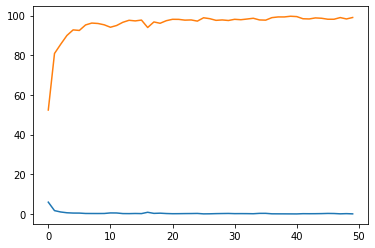

In [13]:
from torch import cuda
import matplotlib.pyplot as plt

device = "cuda" if cuda.is_available() else "cpu"

model_param = W2VParam(
    param_dict=dict(
        vocab_size=len(TEXT.vocab),
        input_size=MAX_LEN
    )
)
print(len(TEXT.vocab))

pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)

model = W2VModelWithPretrainedEmbedding(model_param, pre_trained_emb)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)
epochs = 50


epochs_loss_history = []
epochs_accu_history = []

def my_plot(epochs, sth):
    plt.plot(epochs, sth)

for epoch in range(epochs):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    epoch_losses = []
    model.train()
    for _, batch in enumerate(train_iter, 0):
        targets = batch.label.to(device, dtype = torch.long)
       
        outputs = model(batch.text.T)
        loss = loss_function(outputs, batch.label)
        tr_loss += loss.item() 
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _ % 1000 == 0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct * 100)/nb_tr_examples 
            print(f"Training Loss per 1000 steps: {loss_step}")
            print(f"Training Accuracy per 1000 steps: {accu_step}%")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epochs_loss_history.append(epoch_loss)
    epoch_accu = (n_correct * 100)/nb_tr_examples
    epochs_accu_history.append(epoch_accu)
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}%")
    print("=====================")

df = DataFrame(epochs_loss_history, columns=['w2v_epochs_loss_history'])
df["w2v_epochs_accu_history"] = epochs_accu_history
df.to_csv("../data/w2v_history.csv", index=False)
my_plot(range(epochs), epochs_loss_history)
my_plot(range(epochs), epochs_accu_history)

In [14]:
from sklearn.metrics import f1_score

def valid(model, test_iter):
    model.eval()
    tr_loss = 0
    n_correct = 0 
    n_wrong = 0
    total = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    f1 = 0.0
    f1_scores = []
    targets_list = []
    big_idx_list = []
    with torch.no_grad():
        for _, batch in enumerate(test_iter, 0):

            targets = batch.label.to(device, dtype = torch.long)
            targets_list.extend(targets)
            # print(targets)
            outputs = model(batch.text.T).squeeze()
            # print(outputs)
            # 
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            big_idx_list.extend(big_idx)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)
            
            if _% 10 == 0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct * 100) / nb_tr_examples
                print(f"Validation Loss per 10 steps: {loss_step}")
                print(f"Validation Accuracy per 10 steps: {accu_step}%")
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) /nb_tr_examples
    f1 = f1_score(targets_list, big_idx_list, average='macro')
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}%")

    return epoch_accu, f1


In [15]:
acc, f1 = valid(model, test_iter)
print("Accuracy on test data = %0.2f%%" % acc)
print(f"Marco F1 score: {f1}")

Validation Loss per 10 steps: 4.781060218811035
Validation Accuracy per 10 steps: 75.0%
Validation Loss per 10 steps: 14.665742592350403
Validation Accuracy per 10 steps: 78.4090909090909%
Validation Loss per 10 steps: 17.58015831310093
Validation Accuracy per 10 steps: 74.4047619047619%
Validation Loss per 10 steps: 20.919041733578112
Validation Accuracy per 10 steps: 72.1774193548387%
Validation Loss per 10 steps: 19.923817946772587
Validation Accuracy per 10 steps: 71.64634146341463%
Validation Loss per 10 steps: 20.96706506054178
Validation Accuracy per 10 steps: 70.83333333333333%
Validation Loss per 10 steps: 22.39037223495654
Validation Accuracy per 10 steps: 69.67213114754098%
Validation Loss per 10 steps: 22.139217210220945
Validation Accuracy per 10 steps: 70.59859154929578%
Validation Loss per 10 steps: 24.43532047866479
Validation Accuracy per 10 steps: 67.90123456790124%
Validation Loss Epoch: 25.606885118218212
Validation Accuracy Epoch: 66.85393258426966%
Accuracy on tes

In [16]:
output_model_file = '../models/pytorch_w2v_model.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)

print('All files saved')

All files saved


In [17]:
# human annotated testset
df = pd.read_csv("../data/testset_human.csv", index_col=False)
df.head()

,text,label
0,"if you have time, can you correct the titles?",3.0
1,i had really hoped to get some more opinions o...,6.0
2,"i modified it a bit, possibly vote to reopen?",6.0
3,well the only plausible explanation was that y...,1.0
4,is that what indeed occurred?,1.0


In [18]:
testset = DataFrameDataset(
    df=df, 
    fields=(
        ('text', TEXT),
        ('label', LABEL)
    )
)

In [19]:
test_iter = BucketIterator(testset, batch_size=5, sort=False)

In [20]:
acc, f1 = valid(model, test_iter)
print("Accuracy on test data = %0.2f%%" % acc)
print(f"Marco F1 score: {f1}")

Validation Loss per 10 steps: 85.3056869506836
Validation Accuracy per 10 steps: 20.0%
Validation Loss per 10 steps: 131.82897324995562
Validation Accuracy per 10 steps: 9.615384615384615%
Validation Loss Epoch: 131.82897324995562
Validation Accuracy Epoch: 9.615384615384615%
Accuracy on test data = 9.62%
Marco F1 score: 0.06176900584795321
